In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from physDBD import ImportHelper, DataDesc, ParamsTraj, RxnInputsLayer, ParamsTETraj, RxnModel
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
def get_data_dir():
    data_dir = "/Users/oernst/Documents/papers/2021_03_draft/stochastic_simulations/ml_training_data/data_gillespie/"
    vol_exp = 14
    no_ip3r = 100
    vol_dir = "vol_exp_%02d" % vol_exp
    no_ip3r_dir = "ip3r_%05d" % no_ip3r
    data_dir = os.path.join(data_dir, vol_dir, no_ip3r_dir)
    return data_dir

# Transformation

## Calculate

In [4]:
data_desc = DataDesc(
    no_seeds=100,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [5]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

In [6]:
data["ip3_0p100"].shape

(400, 100, 2)

In [7]:
trans_means = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    trans_means[ip3] = np.mean(data[ip3],axis=(0,1))

print("Means: ", trans_means)    

trans_mean = np.mean(np.array(list(trans_means.values())),axis=0)
print("Means: ", trans_mean)

Means:  {'ip3_0p100': array([371.56195, 601.2577 ]), 'ip3_2p000': array([ 3451.841975, 12051.191425])}
Means:  [1911.7019625 6326.2245625]


In [8]:
sums = {}
lengths = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    ds = data[ip3].shape
    arr = np.reshape(pow(data[ip3] - trans_mean,2),(ds[0]*ds[1],ds[2]))
    rs = arr.shape
    sums[ip3] = np.sum(arr,axis=0)
    lengths[ip3] = rs[0]

length = np.sum(list(lengths.values()))
trans_std = np.sum(list(sums.values()), axis=0) / length
trans_std = np.sqrt(trans_std)

print("Std. devs: ", trans_std)

Std. devs:  [1729.21588444 5724.97054985]


## Export

In [9]:
np.savetxt("cache/trans_mean.txt",trans_mean)
np.savetxt("cache/trans_std.txt",trans_std)

## Import

In [10]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Plot

In [87]:
data_desc = DataDesc(
    no_seeds=1,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [11]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

Text(0.5, 0, 'Timepoint (x 0.1s)')

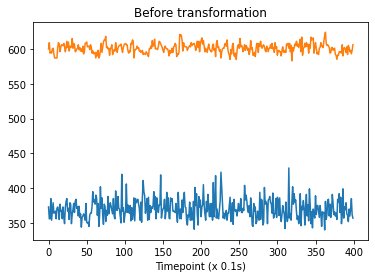

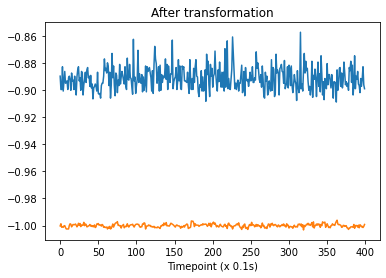

In [12]:
ex_traj = data["ip3_0p100"][:,0]

plt.figure()
plt.plot(ex_traj)
plt.title("Before transformation")
plt.xlabel("Timepoint (x 0.1s)")

plt.figure()
plt.plot((ex_traj - trans_mean)/trans_std)
plt.title("After transformation")
plt.xlabel("Timepoint (x 0.1s)")

# PCA params

## Import transformation

In [4]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Import, calculate PCA

In [9]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [10]:
if not os.path.isdir("cache/cache_params"):
    os.mkdir("cache/cache_params")

In [11]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    data = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(), ip3)
        )
    
    data = (data - trans_mean) / trans_std
    
    # Create params traj and export
    muh = np.zeros(1)
    varh_diag = np.ones(1)
    params_traj = ParamsTraj.fromPCA(data, data_desc.times, muh, varh_diag)

    # Export
    params_traj.export("cache/cache_params/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

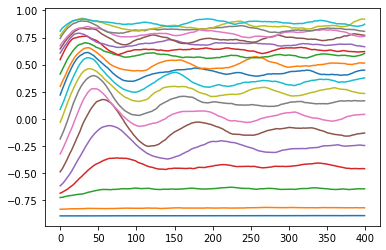

In [12]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)

    b0 = [x.b[0] for x in params_traj.params_traj]

    plt.plot(b0)

# Derivatives

In [4]:
if not os.path.isdir("cache/cache_derivs"):
    os.mkdir("cache/cache_derivs")

In [5]:
alphas = {
    "wt00": 100.0,
    "wt01": 5000.0,
    "b0": 100.0,
    "b1": 100.0,
    "sig2": 5000.0
}
non_zero_vals = list(alphas.keys())

In [6]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    # Differentiate
    paramsTE_traj = params_traj.differentiate_with_TVR(
        alphas=alphas, 
        no_opt_steps=10, 
        non_zero_vals=non_zero_vals
        )
    
    # Export
    paramsTE_traj.export("cache/cache_derivs/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

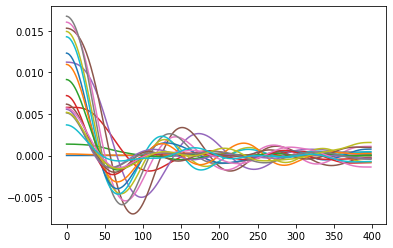

In [9]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    b0 = [x.b_TE[0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(b0)

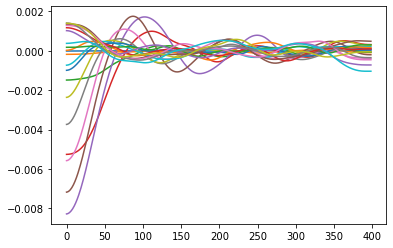

In [10]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    wt00 = [x.wt_TE[0,0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(wt00)

## Re-integrate

In [4]:
if not os.path.isdir("cache/cache_filtered"):
    os.mkdir("cache/cache_filtered")

In [ ]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params and TE traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Integrate
    no_steps = len(params_traj.params_traj) - 1
    params_traj_filtered = ParamsTraj.fromIntegrating(
        paramsTE_traj=paramsTE_traj,
        params_init=params_traj.params_traj[0],
        tpt_start=0,
        no_steps=no_steps
        )
    
    # Export
    params_traj_filtered.export("cache/cache_filtered/%s.txt" % ip3)

## Plot

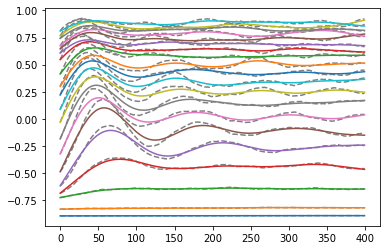

In [12]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj_filtered = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    b0_filtered = [x.b[0] for x in params_traj_filtered.params_traj]
    b0 = [x.b[0] for x in params_traj.params_traj]
    
    plt.plot(b0,color="gray",linestyle="dashed")
    plt.plot(b0_filtered)

# Network

In [50]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [51]:
# Freqs, coffs for fourier
freqs = np.array([1.,2.,3.,4.,5.,6.])
freqs = 2.0 * np.pi * freqs / data_desc.no_times

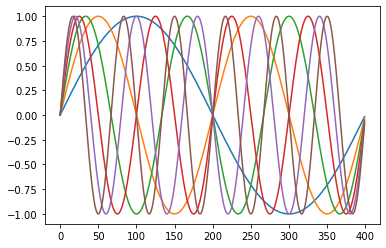

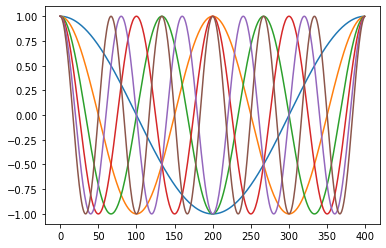

In [52]:
no_tpts = np.arange(0,data_desc.no_times)

plt.figure()
for freq in freqs:
    plt.plot(np.sin(freq * no_tpts))

plt.figure()
for freq in freqs:
    plt.plot(np.cos(freq * no_tpts))

## Reactions

In [53]:
# Rxns
rxn_specs = [
    ("EAT",0,1),
    ("EAT",1,0),
    ("EAT",2,0),
    ("EAT",0,2),
    ("EAT",1,2),
    ("EAT",2,1),
    ("BIRTH",0),
    ("BIRTH",1),
    ("BIRTH",2),
    ("DEATH",0),
    ("DEATH",1),
    ("DEATH",2)
    ]

In [54]:
muh_sin_coeffs_init = np.full(len(freqs),0.0)
muh_cos_coeffs_init = np.full(len(freqs),0.0)
varh_sin_coeffs_init = np.full(len(freqs),0.0)
varh_cos_coeffs_init = np.full(len(freqs),0.0)

In [55]:
# Reaction input layer
rxn_lyr = RxnInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=freqs,
    muh_sin_coeffs_init=muh_sin_coeffs_init,
    muh_cos_coeffs_init=muh_cos_coeffs_init,
    varh_sin_coeffs_init=varh_sin_coeffs_init,
    varh_cos_coeffs_init=varh_cos_coeffs_init,
    rxn_specs=rxn_specs
    )

## Subnet

In [56]:
# Shallow
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.5)
])
'''

# Deep
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3)
])

## Model

In [57]:
model = RxnModel.construct(
    nv=2,
    nh=1,
    rxn_lyr=rxn_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

## Normalizations

In [58]:
def join_dicts(existing_dict, new_dict):
    for key, val in new_dict.items():
        if not key in existing_dict:
            existing_dict[key] = val
        else:
            existing_dict[key] = np.concatenate((existing_dict[key],val))
    return existing_dict

In [59]:
train_inputs = {}
train_outputs = {}

for ip3 in ["ip3_0p400","ip3_0p500","ip3_0p600","ip3_0p700",
            "ip3_0p800","ip3_0p900","ip3_1p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Training data
    train_inputs0 = params_traj.get_tf_inputs_assuming_params0()
    train_outputs0 = paramsTE_traj.get_tf_outputs_assuming_params0(non_zero_outputs=["wt00_TE","b0_TE"])
    
    train_inputs = join_dicts(train_inputs, train_inputs0)
    train_outputs = join_dicts(train_outputs, train_outputs0)

IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000


In [60]:
valid_inputs = {}
valid_outputs = {}

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_1p100",
            "ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
            "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Training data
    valid_inputs0 = params_traj.get_tf_inputs_assuming_params0()
    valid_outputs0 = paramsTE_traj.get_tf_outputs_assuming_params0(non_zero_outputs=["wt00_TE","b0_TE"])
    
    valid_inputs = join_dicts(valid_inputs, valid_inputs0)
    valid_outputs = join_dicts(valid_outputs, valid_outputs0)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


In [61]:
# Normalize outputs

# Normalization size
percent = 0.2
norm_size = int(percent * len(train_outputs["wt00_TE"]))
print("Calculating output normalization from: %d samples" % norm_size)

# Normalize training
train_outputs_mean = {}
train_outputs_std_dev = {}
train_outputs_norm = {}
for key, val in train_outputs.items():
    idxs = np.arange(0,len(val))
    idxs_subset = np.random.choice(idxs,size=norm_size,replace=False)
    val_subset = val[idxs_subset]

    # Mean, std
    train_outputs_mean[key] = np.mean(val_subset,axis=0)
    train_outputs_std_dev[key] = np.std(val_subset,axis=0) + 1e-10

    train_outputs_norm[key] = (val - train_outputs_mean[key]) / train_outputs_std_dev[key]

# Normalize validation
valid_outputs_norm = {}
for key, val in valid_outputs.items():
    valid_outputs_norm[key] = (val - train_outputs_mean[key]) / train_outputs_std_dev[key]

Calculating output normalization from: 558 samples


In [62]:
# Save the output mean/std dev
with open("cache/cache_outputs_mean.txt",'wb') as f:
    pickle.dump(train_outputs_mean, f)
with open("cache/cache_outputs_std_dev.txt",'wb') as f:
    pickle.dump(train_outputs_std_dev, f)

# Try to load
with open("cache/cache_outputs_mean.txt",'rb') as f:
    train_outputs_mean_check = pickle.load(f)
with open("cache/cache_outputs_std_dev.txt",'rb') as f:
    train_outputs_std_dev_check = pickle.load(f)

print(train_outputs_mean, " ; ", train_outputs_mean_check)
print(train_outputs_std_dev, " ; ", train_outputs_std_dev_check)

{'wt00_TE': -0.00043501493256290337, 'b0_TE': 0.0005264810820103232}  ;  {'wt00_TE': -0.00043501493256290337, 'b0_TE': 0.0005264810820103232}
{'wt00_TE': 0.001519306355764682, 'b0_TE': 0.0035999022249293207}  ;  {'wt00_TE': 0.001519306355764682, 'b0_TE': 0.0035999022249293207}


In [63]:
# Reaction layer to use for the normalization
rxn_lyr_norm = RxnInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]]),
    muh_sin_coeffs_init=np.array([1.0]),
    muh_cos_coeffs_init=np.array([1.0]),
    varh_sin_coeffs_init=np.array([1.0]),
    varh_cos_coeffs_init=np.array([1.0]),
    rxn_specs=rxn_specs
    )

# Normalize inputs
model.calculate_rxn_normalization(
    rxn_lyr=rxn_lyr_norm, 
    inputs=train_inputs, 
    percent=0.2
    )

Calculating input normalization from: 558 samples


In [64]:
print("Reaction normalization: Mean: ", model.rxn_mean)
print("Reaction normalization: Std dev: ", model.rxn_std_dev)

Reaction normalization: Mean:  [ 2.1182439e-01 -2.1182439e-01  5.9129223e-02 -5.9129223e-02
  5.9128709e-02 -2.1182439e-01  2.1182439e-01 -5.9129223e-02
  5.9129223e-02  5.9129756e-02  3.9218011e-01  5.8719074e-06
  6.1069906e-01  3.7356020e-14 -5.0442789e-02  4.0702096e-01
  5.8718720e-06 -6.1069906e-01  9.0259939e-14 -5.0442502e-02
  4.4976823e-02 -4.1590479e-01  4.8986476e-10  5.8964542e-03
  3.0584462e-02  4.4976823e-02  2.8538236e-01  1.0752742e-09
 -5.8964528e-03  3.0584553e-02 -6.2922662e-01  0.0000000e+00
 -3.2985946e-03  0.0000000e+00 -1.6478215e-03  0.0000000e+00
  1.5296082e-05  0.0000000e+00 -3.6434278e-01 -1.8216981e-01
 -1.3823269e-01  3.4515883e-06  9.9307695e-10  3.6676350e-14
 -9.0494409e-02  6.2922662e-01  0.0000000e+00  3.2985946e-03
  0.0000000e+00 -1.6507711e-03  0.0000000e+00 -1.5296082e-05
  0.0000000e+00  3.6434278e-01 -1.8217275e-01 -1.3823266e-01
  3.4517991e-06 -1.1292704e-08  1.2596853e-13 -9.0494402e-02]
Reaction normalization: Std dev:  [1.04733340e-01 1.0

# Train

In [65]:
# Test input to the model
input_build = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=1)
input_build = join_dicts(input_build, params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=1))

print("Test input: ", input_build)
print("Test output: ", model(input_build))

Test input:  {'tpt': array([1., 1.]), 'wt': array([[[-6.37040514e-01,  3.95499744e-05]],

       [[-6.37040514e-01,  3.95499744e-05]]]), 'b': array([[0.80914162, 0.99991061],
       [0.80914162, 0.99991061]]), 'sig2': array([1.10735084e-06, 1.10735084e-06])}
Test output:  {'wt00_TE': <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.02387361],
       [0.02387361]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.09112455],
       [0.09112455]], dtype=float32)>}


In [21]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [66]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained/trained_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=False,
    mode='auto', 
    save_frequency=1
    )

model.fit(
    train_inputs, 
    train_outputs_norm, 
    epochs=25, 
    validation_data=(valid_inputs,valid_outputs_norm),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

Epoch 1/25
44/44 [==============================] - 91s 807ms/step - loss: 1.5515 - b0_TE_loss: 0.9427 - wt00_TE_loss: 0.6088 - val_loss: 4.4823 - val_b0_TE_loss: 3.2573 - val_wt00_TE_loss: 1.2251

Epoch 00001: val_loss improved from inf to 4.48233, saving model to trained_lowest_val
INFO:tensorflow:Assets written to: trained_lowest_val/assets
INFO:tensorflow:Assets written to: trained_lowest_val/assets
Epoch 2/25
44/44 [==============================] - 13s 291ms/step - loss: 0.7824 - b0_TE_loss: 0.4892 - wt00_TE_loss: 0.2932 - val_loss: 0.2971 - val_b0_TE_loss: 0.1838 - val_wt00_TE_loss: 0.1132

Epoch 00002: val_loss improved from 4.48233 to 0.29707, saving model to trained_lowest_val
INFO:tensorflow:Assets written to: trained_lowest_val/assets
INFO:tensorflow:Assets written to: trained_lowest_val/assets
Epoch 3/25
44/44 [==============================] - 12s 283ms/step - loss: 0.5977 - b0_TE_loss: 0.3610 - wt00_TE_loss: 0.2367 - val_loss: 1.9990 - val_b0_TE_loss: 1.4592 - val_wt00_T

In [22]:
%tensorboard --logdir logs

## Save model

In [36]:
# Save
model.save("trained/trained", save_traces=False)

INFO:tensorflow:Assets written to: trained/assets


## Import trained model

In [67]:
model_trained = tf.keras.models.load_model("trained/trained_lowest_val")

In [42]:
params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % "ip3_0p400", nv=2, nh=1)
int_input = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=0)
print(int_input)
int_output = model_trained(int_input)
print(int_output)

{'tpt': array([0.]), 'wt': array([[[-2.46492819e-01,  8.98171166e-05]]]), 'b': array([[-0.68373541, -0.6834573 ]]), 'sig2': array([1.49628027e-06])}
{'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.8467426]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.91050607]], dtype=float32)>}


## Integrate

In [43]:
# Load mean / std. dev. output normalization
with open("cache/cache_outputs_mean.txt",'rb') as f:
    train_outputs_mean = pickle.load(f)
with open("cache/cache_outputs_std_dev.txt",'rb') as f:
    train_outputs_std_dev = pickle.load(f)

train_outputs_mean

{'wt00_TE': -0.00031232439026682136, 'b0_TE': 0.0006091167043483266}

In [46]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p400", nv=2, nh=1)
params_start = params_traj.params_traj[0]

params_traj_int = model_trained.integrate(
    params_start=params_start,
    tpt_start=0,
    no_steps=120,
    time_interval=0.1,
    output_mean=train_outputs_mean,
    output_std_dev=train_outputs_std_dev
)

(1, 1), dtype=float32, numpy=array([[0.49765998]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.002695117362870041, 'b0_TE': 0.002458719013591484}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6752613]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.47843054]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.0026827233415791327, 'b0_TE': 0.0023872508999217903}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6736778]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.46905047]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.00268048284041816, 'b0_TE': 0.002352388937652749}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6514827]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.44794768]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.0026490780411140176, 'b0

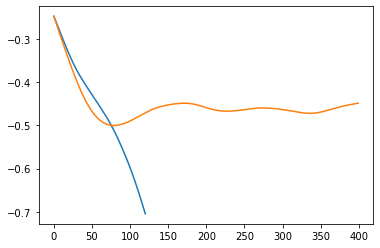

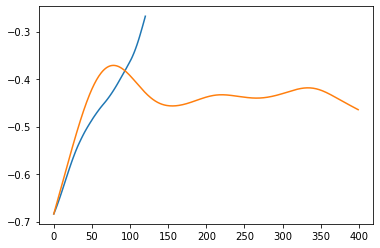

In [48]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)

plt.figure()
plt.plot(b0)
plt.plot(b0_true)

In [31]:
wt00

[-0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607]